In [1]:
!pip install --upgrade tensorflow-addons

import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import time
from tensorflow.keras.utils import to_categorical
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

print(f'tf_ver={tf.__version__} / tfa_ver={tfa.__version__}')

train_data, validation_data = tf.keras.datasets.cifar10.load_data()



     |████████████████████████████████| 1.1 MB 4.7 MB/s 
tf_ver=2.8.0 / tfa_ver=0.16.1
170508288/170498071 [==============================] - 4s 0us/step


In [2]:


@tf.function
def image_augmentation(images, labels, num_classes, 
                       shift_range=0.,
                       cval=0.0, cutout_size=None, cutout_num=1,
                       mix_prob=1.0, 
                       alpha=None
                       ):

    img_shape = images.shape[-3:]
    img_width = img_shape[1]
    img_height = img_shape[0]

    def cutout(image, cval=0, cnum = 6, csize = 0.25):
        DIM = image.shape[0]
        for k in range( cnum ):
            # CHOOSE RANDOM LOCATION
            x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
            y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
            # COMPUTE SQUARE 
            WIDTH = tf.cast( csize*DIM,tf.int32)
            ya = tf.math.maximum(0,y-WIDTH//2)
            yb = tf.math.minimum(DIM,y+WIDTH//2)
            xa = tf.math.maximum(0,x-WIDTH//2)
            xb = tf.math.minimum(DIM,x+WIDTH//2)
            # DROPOUT IMAGE
            one = image[ya:yb,0:xa,:]
            two = tf.fill([yb-ya,xb-xa,3], tf.cast(cval, image.dtype) ) 
            three = image[ya:yb,xb:DIM,:]
            middle = tf.concat([one,two,three],axis=1)
            image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM,:,:]],axis=0)

        # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR 
        image = tf.reshape(image,[DIM,DIM,3])
        return image

    def mixup(images, labels, CLASSES, PROBABILITY = 1.0):
        BATCH_SIZE = images.shape[0]
        DIM = images.shape[1]
        imgs = []; labs = []
        for j in range(BATCH_SIZE):
            k = tf.cast( tf.random.uniform([],0,BATCH_SIZE),tf.int32)
            P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.float32)
            a = tf.random.uniform([],0.0,0.5, dtype=tf.float32)*P
            img1 = images[j,]
            img2 = images[k,]
            imgs.append((1-a)*img1 + a*img2)

            lab1 = tf.one_hot(labels[j],CLASSES)
            lab2 = tf.one_hot(labels[k],CLASSES)
            labs.append((1-a)*lab1 + a*lab2)
        image2 = tf.reshape(tf.stack(imgs),(BATCH_SIZE,DIM,DIM,3))
        label2 = tf.reshape(tf.stack(labs),(BATCH_SIZE,CLASSES))
        return image2,label2

    def random_color_shift(image, c_shift):
        image = image + tf.random.uniform([3], -c_shift, c_shift, dtype=tf.float32)
        return image


    def basic_augmentation(x, shift):
        padding = int(shift*img_width)
        x = tf.image.random_flip_left_right(x)
        x = tf.pad(x, [ [padding,padding], [padding,padding], [0,0]], 'REFLECT')
        x = tf.image.random_crop(x, [img_width,img_width,3])
        return x

    images = tf.map_fn( lambda image: random_color_shift(image, c_shift=0.2), images)
    images = tf.map_fn(lambda image: basic_augmentation(image, shift_range), images)
    if mix_prob != 0.0:
        images, labels = mixup(images, labels, num_classes, mix_prob*alpha)
    else:
        labels = tf.one_hot(labels, num_classes)
        BATCH_SIZE = images.shape[0]
        labels = tf.reshape(labels,(BATCH_SIZE,num_classes))

    if cutout_size!=None and cutout_num!=0:
        images = tf.map_fn(lambda image: cutout(image,cval=cval, csize=cutout_size, cnum=cutout_num), images)

    return images, labels

def make_dataset(train_data, validation_data, batch_size, num_classes,resize=224, cutout_size=0.25, cutout_num=1, mix_prob=0.0, epochs=None):
    (x_train, label_train) = train_data
    (x_test, label_test) = validation_data

    train_len = len(x_train)
    test_len = len(x_test)

    ds_train = tf.data.Dataset.from_tensor_slices(train_data)
    ds_train = ds_train.shuffle(train_len).batch(batch_size,drop_remainder=True)
    ds_validation = tf.data.Dataset.from_tensor_slices(validation_data)
    ds_validation = ds_validation.batch(batch_size)

    if epochs:
        counter = tf.Variable(0, dtype=tf.float32, name="aug_counter")

    N, W, H, C = x_train.shape
    mean_val = np.mean( np.reshape(x_train, (N*W*H, C)), axis=0 ) / 255.0
    std_val = np.std( np.reshape(x_train, (N*W*H, C)), axis=0 ) / 255.0
    image_mean = tf.constant(mean_val, dtype=tf.float32)
    image_std = tf.constant(std_val, dtype=tf.float32)

    def data_augmentation(images, labels, aug):
        images = tf.cast(images, dtype=tf.float32)/255.0
        images = (images-image_mean)/image_std
        if aug:
            if epochs:
                counter.assign_add(1)
                total_steps = (N//batch_size)*epochs
                alpha = tf.clip_by_value(counter/total_steps, 0.0, 1.0)
            else:
                alpha = 1.0
            images,labels = image_augmentation(images, labels, num_classes, 
                                        shift_range=0.2,
                                        cval=0.0,
                                        cutout_size=cutout_size, cutout_num=cutout_num,
                                        mix_prob = mix_prob, alpha=alpha
                                        )
        else:
            labels = tf.one_hot(labels, num_classes)
            # BATCH_SIZE = images.shape[0]
            labels = tf.reshape(labels,(-1,num_classes))
        if W!=resize:
            images = tf.image.resize(images,(resize,resize), method=tf.image.ResizeMethod.BICUBIC)
        return images, labels

    ds_train = ds_train.map(lambda image, label: data_augmentation(image, label,True), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

    ds_validation = ds_validation.map(lambda image, label: data_augmentation(image, label,False), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds_validation = ds_validation.prefetch(tf.data.experimental.AUTOTUNE)
    return ds_train, ds_validation

def showHistory(history):

    # Setting Parameters
    acc = history['acc']
    val_acc = history['val_acc']
    max_acc = max(val_acc)
    print('max:',max_acc)

    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(16,6))
 
    # Accracy
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'r', label='Training')
    plt.plot(epochs, val_acc, 'b', label='Validation')
    plt.title('Accuracy')
    plt.grid()
    plt.legend()

    # Loss 
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'r', label='Training')
    plt.plot(epochs, val_loss, 'b', label='Validation')
    plt.title('Loss')
    if max(max(loss),max(val_loss))>10.0:
        plt.ylim(0.0,10.0)
    plt.grid()
    plt.legend()
    plt.show()







ViT

In [3]:
import tensorflow as tf
from tensorflow.keras import layers

class SkipConnection(tf.keras.layers.Layer):
    def __init__(self, drop_rate=0.0, **kwargs):
        super().__init__(**kwargs)
        self.drop_rate = drop_rate

    def get_config(self):
        config = {'drop_rate': self.drop_rate}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, inputs):
        shortcut, x = inputs
        if self.drop_rate != 0.0:
            x = layers.Dropout(rate=self.drop_rate, noise_shape=(None,1,1))(x)
        x = layers.Add()([shortcut,x])
        return x

class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, num_patches, d_model, **kwargs):
        self.num_patches = num_patches
        self.d_model = d_model
        super().__init__(**kwargs)
    def get_config(self):
        config = {'num_patches': self.num_patches,
                  'd_model': self.d_model}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))
    def build(self, input_shape):
        self.pos_emb = self.add_weight("pos_emb", 
                                       shape=(1, self.num_patches + 1, self.d_model),
                                       initializer=tf.initializers.RandomNormal(stddev=0.02))
        self.class_emb = self.add_weight("class_emb", 
                                         shape=(1, 1, self.d_model),
                                         initializer=tf.initializers.Zeros())
        super().build(input_shape)
    def call(self,x):
        batch_size = tf.shape(x)[0]
        class_emb = tf.broadcast_to(
            self.class_emb, [batch_size, 1, self.d_model]
        )
        x = tf.concat([class_emb, x], axis=1)
        x = x + self.pos_emb
        return x
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]+1, input_shape[2], input_shape[3])


def vit(
    image_size = 224,
    patch_size = 16,
    channels = 3,
    d_model = 768,
    num_classes =21843,
    mlp_dim = 3072,
    num_layers = 12,
    num_heads = 12,
    l2_reg = 0.0,
    dropout = 0.1,
    attention_dropout = 0.0,
    stoch_depth=0.0):

    dense_kwargs = {
        'kernel_initializer':'glorot_normal',
        'bias_initializer': tf.keras.initializers.RandomNormal(stddev=1e-2),
        'kernel_regularizer':tf.keras.regularizers.l2(l2_reg)
        }
    lnorm_kwargs = {'epsilon':1e-6}

    def MultiHead_SelfAttention(inputs, d_model, num_heads, dropout,prefix):
        projection_dim = d_model // num_heads

        query = layers.Dense(d_model, name = prefix+"_Dense_query", **dense_kwargs)(inputs)
        key   = layers.Dense(d_model, name = prefix+"_Dense_key"  , **dense_kwargs)(inputs)
        value = layers.Dense(d_model, name = prefix+"_Dense_value", **dense_kwargs)(inputs)
        query = layers.Reshape((-1, num_heads, projection_dim),name = prefix+"_Reshape_query")(query)
        key   = layers.Reshape((-1, num_heads, projection_dim),name = prefix+"_Reshape_key"  )(key)
        value = layers.Reshape((-1, num_heads, projection_dim),name = prefix+"_Reshape_value")(value)

        query = layers.Permute((2, 1, 3), name = prefix+"_Permute_query")(query)
        key   = layers.Permute((2, 1, 3), name = prefix+"_Permute_key")(key)
        value = layers.Permute((2, 1, 3), name = prefix+"_Permute_value")(value)

        score = tf.matmul(query, key, transpose_b=True)
        score = score/K.sqrt(K.cast(projection_dim, 'float32'))
        attention_probs = layers.Activation("softmax", name = prefix+"_Softmax_projection")(score) 
        if dropout != 0.0:
            attention_probs = layers.Dropout(dropout, name=prefix+"_Dropout_projection")(attention_probs)

        attention = tf.matmul(attention_probs, value)
        attention = layers.Permute((2, 1, 3), name = prefix+"_Permute_attention")(attention)
        attention = layers.Reshape( (-1, d_model), name = prefix+"_Reshape_attention")(attention)
        output = layers.Dense(d_model, name = prefix+"_Dense_out", **dense_kwargs)(attention)
        if dropout != 0.0:
            output = layers.Dropout(dropout, name=prefix+"_Dropout_out")(output)

        return output

    x = inputs = layers.Input(shape=(image_size, image_size, channels), name="Input")
    
    num_patches = (image_size // patch_size) ** 2
    patch_dim = channels * patch_size ** 2
    x = layers.Lambda( lambda y: tf.nn.space_to_depth(y, patch_size), name='Embedding_space2depth' )(x)
    x = layers.Dense(d_model, name='Embedding_fc')(x)
    x = layers.Reshape((num_patches,d_model), name='Embedding_Reshape')(x)
    x = PatchEmbedding(num_patches,d_model, name="PatchEmbedding")(x)

    if dropout != 0.0:
       x = layers.Dropout(dropout, name='Embedding_Dropout')(x)

    # Encoder
    for i in range(num_layers):
        prefix = f'Encoder_{i}'
        layer_drop_rate =  (i+1)*stoch_depth/num_layers

        # Attention block.
        shortcut = x
        x = layers.LayerNormalization(name = prefix+"_Attention_LayerNorm")(x)
        x = MultiHead_SelfAttention(x, d_model, num_heads, attention_dropout, prefix=prefix+"_MHSA" )
        x = SkipConnection(layer_drop_rate,name=prefix+"_Attention_SkipConnection")([shortcut,x])
        # MLP block.
        shortcut = x
        x = layers.LayerNormalization(name=prefix+"_MLP_LayerNorm",**lnorm_kwargs)(x)
        x = layers.Dense(mlp_dim, name=prefix+"_MLP_Dense_0",**dense_kwargs)(x)
        x = layers.Activation(tf.nn.gelu, name=prefix+"_MLP_GeLU")(x)
        if dropout != 0.0:
            x = layers.Dropout(dropout, name=prefix+"_MLP_Dropout")(x)
        x = layers.Dense(d_model, name=prefix+"_MLP_Dense_1", **dense_kwargs)(x)
        if dropout != 0.0:
            x = layers.Dropout(dropout, name=prefix+"_MLP_Dropout_hidden")(x)
        x = SkipConnection(layer_drop_rate,name=prefix+"_MLP_SkipConnection")([shortcut,x])

    x = layers.LayerNormalization(name="Encoder_Norm", **lnorm_kwargs)(x)
    x = layers.Dense(num_classes, kernel_initializer=tf.keras.initializers.Zeros() , name="Head_Dense")(x[:, 0])
    return tf.keras.Model(inputs,x) 


MLP-Mixer: An all-MLP Architecture for Vision<br>
https://arxiv.org/abs/2105.01601<br>
https://github.com/google-research/vision_transformer/blob/linen/vit_jax/models_mixer.py<br>


In [4]:
#https://github.com/google-research/vision_transformer/blob/linen/vit_jax/models_mixer.py
#https://arxiv.org/abs/2105.01601

import tensorflow as tf
from tensorflow.keras import layers

class SkipConnection(tf.keras.layers.Layer):
    def __init__(self, drop_rate=0.0, **kwargs):
        super().__init__(**kwargs)
        self.drop_rate = drop_rate

    def get_config(self):
        config = {'drop_rate': self.drop_rate}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, inputs):
        shortcut, x = inputs
        if self.drop_rate != 0.0:
            x = layers.Dropout(rate=self.drop_rate, noise_shape=(None,1,1))(x)
        x = layers.Add()([shortcut,x])
        return x

def mlp_mixer(
    image_size = 224,
    patch_size = 16,
    channels = 3,
    num_classes = 1000,
    num_blocks = 12,
    hidden_dim = 768,
    tokens_mlp_dim = 384,
    channels_mlp_dim = 3072,
    l2_reg=0.0,
    stoch_depth = 0.1,
    dropout = 0.0):

    dense_kwargs = {
        'kernel_initializer':'glorot_normal',
        'bias_initializer': tf.keras.initializers.RandomNormal(stddev=1e-2),
        'kernel_regularizer':tf.keras.regularizers.l2(l2_reg)
        }
    lnorm_kwargs = {'epsilon':1e-6}

    def MLP_Block(x, mlp_dim, dropout, prefix):
        dim = x.shape[-1]
        x = layers.Dense(mlp_dim, name=prefix+'_fc1', **dense_kwargs)(x)
        x = layers.Activation(tf.nn.gelu, name=prefix+'_activation')(x)
        if dropout!=0.0:
            x = layers.Dropout(dropout, name=prefix+'_dropout1')(x)
        x = layers.Dense(dim, name=prefix+'_fc2', **dense_kwargs)(x)
        # if dropout!=0.0:
        #     x = layers.Dropout(dropout, name=prefix+'_dropout2')(x)
        return x

    def Mixer_Block(x, tokens_mlp_dim, channels_mlp_dim, stoch_depth, dropout, prefix):
        y = layers.LayerNormalization(name = prefix+"_norm")(x)
        y = layers.Permute((2, 1), name = prefix+"_swap_axes")(y)
        y = MLP_Block(y, tokens_mlp_dim, dropout, prefix=prefix+'_Token_Mixing')
        y = layers.Permute((2, 1), name = prefix+"_swap_axes_restore")(y)
        x = SkipConnection( stoch_depth, name=prefix+'_skipconnect1')((x,y))

        y = layers.LayerNormalization(name = prefix+"_norm2")(x)
        y = MLP_Block(y, channels_mlp_dim, dropout, prefix=prefix+'_Channel_Mixing')
        x = SkipConnection( stoch_depth, name=prefix+'_skipconnect2')((x,y))
        return x


    x = inputs = layers.Input(shape=(image_size, image_size, channels), name="Input")
    
    num_patches = (image_size // patch_size) ** 2
    patch_dim = channels * patch_size ** 2
    x = layers.Lambda( lambda y: tf.nn.space_to_depth(y, patch_size), name='Stem_space2depth' )(x)
    x = layers.Dense(hidden_dim, name='Stem_fc', **dense_kwargs)(x)
    x = layers.Reshape((num_patches,hidden_dim), name='Stem_reshape')(x)
    if dropout!=0.0:
        x = layers.Dropout(dropout, name='Stem_dropout')(x)

    for i in range(num_blocks):
        block_stoch_depth =  (i+1)*stoch_depth/num_blocks
        x = Mixer_Block(x, tokens_mlp_dim, channels_mlp_dim, block_stoch_depth, dropout,prefix=f'Mixer_{i+1}')

    x = layers.LayerNormalization(name="Head_norm", **lnorm_kwargs)(x)
    x = layers.GlobalAveragePooling1D(name='Head_averaging')(x)
    x = layers.Dense(num_classes, kernel_initializer=tf.keras.initializers.Zeros() , name="Head_fc")(x)
    return tf.keras.Model(inputs,x) 



{'num_classes': 10, 'image_size': 32, 'l2_reg': 0.0001, 'stoch_depth': 0.1, 'dropout': 0.0, 'patch_size': 4, 'num_blocks': 12, 'hidden_dim': 240, 'channels_mlp_dim': 960, 'tokens_mlp_dim': 120}
params 5756698
Epoch 1/50
195/195 [==============================] - 70s 121ms/step - loss: 3.3711 - acc: 0.1791 - val_loss: 3.2116 - val_acc: 0.2473
Epoch 2/50
195/195 [==============================] - 9s 46ms/step - loss: 3.2574 - acc: 0.2482 - val_loss: 3.0182 - val_acc: 0.3527
Epoch 3/50
195/195 [==============================] - 9s 46ms/step - loss: 3.1502 - acc: 0.3148 - val_loss: 2.8275 - val_acc: 0.4435
Epoch 4/50
195/195 [==============================] - 10s 50ms/step - loss: 3.0548 - acc: 0.3781 - val_loss: 2.7213 - val_acc: 0.4764
Epoch 5/50
195/195 [==============================] - 10s 52ms/step - loss: 2.9900 - acc: 0.4027 - val_loss: 2.6240 - val_acc: 0.5115
Epoch 6/50
195/195 [==============================] - 9s 46ms/step - loss: 2.9223 - acc: 0.4234 - val_loss: 2.5924 - val_a

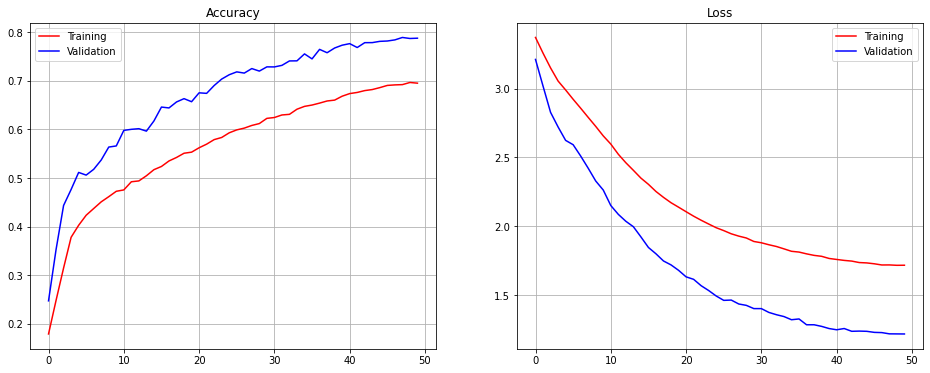

Time: 914.8549661636353
Params: {'image_size': 32, 'max_lr': 0.1, 'min_lr_ratio': 0.01, 'wd': 0.0001, 'stoch_depth': 0.1, 'dropout': 0.0, 'model_name': 'Mixer-240_4', 'batch_size': 256, 'epochs': 50, 'input_size': 32}
History File : 20220506001315_Mixer-240_4.hist


In [5]:
import datetime
from pytz import timezone
def build_model_for_cifar10(params):
    MODEL_NAME = params['model_name']
    image_size=params['image_size']

    mixer_kwargs = None
    s2mixer_kwargs = None
    kwargs = {
            'num_classes' : 10, 
            'image_size' : image_size,
            'l2_reg':params['wd'],
            'stoch_depth':params['stoch_depth'],
            'dropout':params['dropout']
        }
    if MODEL_NAME == 'ViT-Ti_4':
        vit_kwargs = dict(kwargs,**{
            'patch_size' : 4,
            'd_model' : 192,
            'mlp_dim' : 192*4,
            'num_layers' : 12,
            'num_heads' : 3,
        })
    elif MODEL_NAME == 'ViT-S_4':
        vit_kwargs = dict(vkwargs,**{
            'patch_size' : 4,
            'd_model' : 386,
            'mlp_dim' : 386*4,
            'num_layers' : 12,
            'num_heads' : 12,
        })
    elif MODEL_NAME == 'Mixer-240_4':
        mixer_kwargs = dict(kwargs,**{
            'patch_size' : 4,
            'num_blocks' : 12,
            'hidden_dim' : 240,
            'channels_mlp_dim' : 240*4,
            'tokens_mlp_dim' : 240//2,
        })
    elif MODEL_NAME == 'Mixer-B_16':
        mixer_kwargs = dict(kwargs,**{
            'patch_size' : 16,
            'num_blocks' : 12,
            'hidden_dim' : 768,
            'channels_mlp_dim' : 3072,
            'tokens_mlp_dim' : 384,
        })
    elif MODEL_NAME == 'Mixer-S_16':
        mixer_kwargs = dict(kwargs,**{
            'patch_size' : 16,
            'num_blocks' : 8,
            'hidden_dim' : 512,
            'channels_mlp_dim' : 512*4,
            'tokens_mlp_dim' : 256
        })
    if MODEL_NAME.startswith('Mixer'):
        print(mixer_kwargs)
        model = mlp_mixer(**mixer_kwargs)
    elif MODEL_NAME.startswith('ViT'):
        print(vit_kwargs)
        model = vit(**vit_kwargs)

    
    print('params', model.count_params())
    return model

class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, **kwargs):
        super().__init__()
        self.lr = kwargs['lr']
        self.min_lr_ratio = kwargs['min_lr_ratio']
        self.total_steps = kwargs['total_steps']
        self.warmup = kwargs['warmup']

    def get_config(self):
        config = {"lr": float(self.lr), 
                  "min_lr_ratio": float(self.min_lr_ratio), 
                  "warmup": float(self.warmup),
                  "total_steps": float(self.total_steps),
                  }
        return config

    def __call__(self, step):
        step_l = step-self.warmup
        total_l = self.total_steps-self.warmup
        def warmup_func():
            return step*self.lr/self.warmup

        def cooldown_func():
            max_lr = self.lr
            min_lr = max_lr*self.min_lr_ratio
            return min_lr + 0.5*(max_lr-min_lr)*(1.0+tf.math.cos(step_l/total_l*np.pi))

        return tf.cond(step <= self.warmup, warmup_func, cooldown_func)

def train(model, optimizer, epochs, ds_train, ds_validation, label_smoothing=0.0):
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing, from_logits=True)
    acc = tf.keras.metrics.CategoricalAccuracy(name='acc')
    model.compile(optimizer=optimizer,
                  loss=loss, metrics=[acc])
    history = model.fit(ds_train, epochs=epochs,
                        validation_data=ds_validation, callbacks=[])
    showHistory(history.history)
    return history.history
    
def test_params():
    BATCH_SIZE = 256
    EPOCHS = 50
    steps_per_epoch = 50000 // BATCH_SIZE

    label_smoothing = 0.1
    cutout_size= 0.4
    cutout_num = 0
    mix_prob = 1.0
    input_size = 32

    default_params = {
        'image_size':input_size,
        'max_lr':1e-1, 
        'min_lr_ratio':1e-2, 
        'wd':1e-4,
        'stoch_depth':0.1,
        'dropout':0.0,
        }

    total_steps = steps_per_epoch * EPOCHS
    warmup_steps = 2000

    ds_train, ds_validation = make_dataset(train_data, validation_data, BATCH_SIZE, 10,
                                        resize=input_size,cutout_size=cutout_size, cutout_num=cutout_num, 
                                        mix_prob=mix_prob,
                                        epochs=None)

    ViT_Ti4_params       = dict(default_params, model_name='ViT-Ti_4')
    Mixer_240_params     = dict(default_params, model_name='Mixer-240_4')
    Mixer_240_do_params  = dict(default_params, model_name='Mixer-240_4', dropout=0.1)

    params_list = [  Mixer_240_params]
    for params in params_list:
        lf_scheduler = LRSchedule(lr=params['max_lr'], min_lr_ratio=params['min_lr_ratio'], total_steps=total_steps, warmup=warmup_steps)

        optimizer = tf.keras.optimizers.SGD(lf_scheduler, momentum=0.9, global_clipnorm=1.0)
        model_name = params['model_name']
        model = build_model_for_cifar10(params)
        start_time = time.time()

        history = train(model,  optimizer, EPOCHS, ds_train, ds_validation, label_smoothing)

        print('Time:', time.time()-start_time)
        msg_param = str(dict(params, batch_size=BATCH_SIZE, epochs=EPOCHS,input_size=input_size))
        eval_max = max(history['val_acc'])
        msg_result = f'accuracy={eval_max*100:.2f}'

        print('Params:', msg_param)
        endtime = datetime.datetime.now(tz= timezone('Asia/Tokyo')).strftime('%Y%m%d%H%M%S')
        filename = f"{endtime}_{model_name}.hist"
        print(f'History File : {filename}')
        with open(filename, 'wb+') as f:
            import pickle
            pickle.dump(history, f)   

        # send_slack_message(f'{msg_param}\n{msg_result}') 

        # weights_filename = model_name+'_param.hdf5'
        # model.save_weights(weights_filename)

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

with strategy.scope():
    test_params()
